In [1]:
#Librerias
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

%matplotlib inline

### Data
* **df_cross_prod**: contiene el par item a - item b y el número de boleta en donde aparece el par
* **product**: contiene el detalle del item

In [2]:
#df_cross_prod.to_csv('df_cross_prod.gzip',compression='gz',sep=';')
df_cross_prod = pd.read_csv('data/df_cross_prod.gzip',header=0,sep=';',compression='gzip')
df_cross_prod.head()
df_cross_prod.reset_index(inplace=True)
df_cross_prod.drop(['Unnamed: 0','index'],inplace=True, axis=1)
#df_cross_prod.head()

In [3]:
product = pd.read_csv('data/product.csv',sep=';',header=0,index_col=False)
#product.head()

In [ ]:
ab_item_fact = df_cross_prod.groupby(['item_a','item_b']).agg({'sales_return_document_num': pd.Series.nunique})
ab_item_fact.reset_index(inplace=True)
ab_item_fact.info(memory_usage=True,null_counts=True)

In [ ]:
#nodes = ab_item_fact['item_a'].unique()

In [ ]:
#edges = ab_item_fact[['item_a','item_b']].values.tolist()

In [ ]:
#print('Cantidad de nodos: '+str(len(nodes)))
#print('Cantidad de edges: '+str(len(edges)))

In [ ]:
ab_item_fact = pd.merge(ab_item_fact,product[['item_id','web_category_name']],left_on = ['item_a'], right_on=['item_id'],how='left')
#ab_item_fact = pd.merge(ab_item_fact,product[['item_id','web_category_name']],on=['item_id_'],how='left')
#ab_item_fact.head()

In [ ]:
ab_item_fact = pd.merge(ab_item_fact,product[['item_id','web_category_name']],left_on = ['item_b'], right_on=['item_id'],how='left')
#ab_item_fact.head()

In [ ]:
ab_item_fact.drop(['item_id_x','item_id_y'],inplace=True,axis=1)
#rename_col = {'web_category_name_x':'cat_a','web_category_name_y','cat_b'}
ab_item_fact.rename(columns={'web_category_name_x':'cat_a','web_category_name_y':'cat_b'},inplace=True)
#ab_item_fact.head()

In [ ]:
ab_item_fact['item_a'].count()

In [ ]:
ab_item_fact.drop(ab_item_fact[ab_item_fact['cat_a'].isnull()].index, inplace=True)
ab_item_fact.drop(ab_item_fact[ab_item_fact['cat_b'].isnull()].index, inplace=True)

In [ ]:
ab_item_fact['item_a'].count()

In [ ]:
ab_cat_fact = ab_item_fact.groupby(['cat_a','cat_b']).agg({'sales_return_document_num':'sum'})
#ab_cat_fact.head()

In [ ]:
ab_cat_fact.reset_index(inplace=True)
#ab_cat_fact.head()

In [ ]:
nodes = ab_cat_fact['cat_a'].unique()

In [ ]:
nodes

In [ ]:
edges = ab_item_fact[['cat_a','cat_b']]#.values.tolist()
edges.drop_duplicates(subset=['cat_a','cat_b'],keep='first',inplace=True)
edges = edges.values.tolist()

In [ ]:
print('Cantidad de nodos: '+str(len(nodes)))
print('Cantidad de edges: '+str(len(edges)))

#### Disaster!

In [63]:
import networkx as nx
import community
from cytoolz import keymap, keyfilter, valmap, valfilter, itemmap, frequencies
import random

prod_graph = nx.Graph()
prod_graph.add_nodes_from(nodes)
print('Nodes added')
prod_graph.add_edges_from(edges)
print('Edges added')

import time
start_time = time.time()
dendrogram = community.generate_dendrogram(prod_graph, random_state=1312)
print("Dendrogram created in {:.2f} seconds ---".format(time.time() - start_time))


for level in range(len(dendrogram) - 1) :
    print(level)
    print("Partition at level", level,"is", partition_at_level(dendo, level))

import time
start_time = time.time()    
communities = community.partition_at_level(dendrogram, len(dendrogram) - 1)
print("Communities created in {:.2f} seconds ---".format(time.time() - start_time))
community_sizes = frequencies(communities.values())
print('# of Communities:', len(community_sizes))

Nodes added
Edges added
Dendrogram created in 5.81 seconds ---
Communities created in 0.00 seconds ---
# of Communities: 6


In [74]:
network = prod_graph

In [64]:
for level in range(len(dendrogram) - 1) :
    print(level)
    print("Partition at level", level,"is", partition_at_level(dendo, level))

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161']


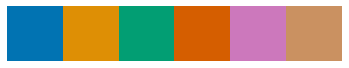

In [65]:
from matplotlib.colors import rgb2hex

palette = sns.color_palette('colorblind', n_colors=len(community_sizes))
# esto convierte cada color a una representación hexadecimal, como la usada en los Sitios Web
palette = list(map(rgb2hex, palette))
print(palette)
# este método grafica la paleta de colores
sns.palplot(palette)
plt.axis('off');

In [75]:
community_structure = nx.DiGraph()

node_from_h = {}

dst_to_node = None

for level, comms in enumerate(dendrogram, start=0):
    if dst_to_node is None:
        src_to_node = {}
    else:
        src_to_node = dst_to_node
        
    dst_to_node = {}
    
    for src, dst in comms.items():
        if not src in src_to_node:
            src_node_id = community_structure.number_of_nodes()
            community_structure.add_node(src_node_id)
            src_to_node[src] = src_node_id
            
            node_from_h[src_node_id] = src
            
        if not dst in dst_to_node:
            dst_node_id = community_structure.number_of_nodes()
            community_structure.add_node(dst_node_id)
            dst_to_node[dst] = dst_node_id
            
        community_structure.add_edge(dst_to_node[dst], src_to_node[src])
        
root_node_id = community_structure.number_of_nodes()
community_structure.add_node(root_node_id)

for src, dst in dendrogram[-1].items():
    community_structure.add_edge(root_node_id, dst_to_node[dst])
    
community_structure.number_of_nodes(), community_structure.number_of_edges()

(1152, 1151)

In [76]:
# source: https://stackoverflow.com/questions/34803197/fast-b-spline-algorithm-with-numpy-scipy
import scipy.interpolate as si
import numpy as np

def scipy_bspline(cv, n=100, degree=3, periodic=False):
    """ Calculate n samples on a bspline

        cv :      Array ov control vertices
        n  :      Number of samples to return
        degree:   Curve degree
        periodic: True - Curve is closed
    """
    cv = np.asarray(cv)
    count = cv.shape[0]

    # Closed curve
    if periodic:
        kv = np.arange(-degree,count+degree+1)
        factor, fraction = divmod(count+degree+1, count)
        cv = np.roll(np.concatenate((cv,) * factor + (cv[:fraction],)),-1,axis=0)
        degree = np.clip(degree,1,degree)

    # Opened curve
    else:
        degree = np.clip(degree,1,count-1)
        kv = np.clip(np.arange(count+degree+1)-degree,0,count-degree)

    # Return samples
    max_param = count - (degree * (1-periodic))
    spl = si.BSpline(kv, cv, degree)
    return spl(np.linspace(0,max_param,n))

In [77]:
node_to_h = itemmap(reversed, node_from_h)
community_structure_undirected = community_structure.to_undirected()

def edge_to_spline(src, dst, n_points=100, smoothing_factor=1):
    edge_path = nx.shortest_path(community_structure_undirected, node_to_h[src], node_to_h[dst])
    edge_cp = [hierarchical_pos[node_id] for node_id in edge_path]
    
    try:    
        smooth_edge = scipy_bspline(edge_cp, degree=min(len(edge_cp) - 1, 3), n=n_points)
        source_edge = np.vstack((np.linspace(edge_cp[0][0], edge_cp[-1][0], num=n_points, endpoint=True),
                                 np.linspace(edge_cp[0][1], edge_cp[-1][1], num=n_points, endpoint=True))).T
        
        if smoothing_factor < 1.0:
            smooth_edge = smooth_edge * smoothing_factor + source_edge * (1.0 - smoothing_factor)
        
        return smooth_edge
    except ValueError:
        print(src, dst, 'error')
        return None

In [78]:
print('¿Es árbol la estructura de comunidades?', nx.is_tree(community_structure))
print('¿Es árbol la red de músicos?', nx.is_tree(network))

¿Es árbol la estructura de comunidades? True
¿Es árbol la red de músicos? False


In [79]:
hierarchical_pos = nx.drawing.nx_pydot.graphviz_layout(community_structure, prog='twopi', root=root_node_id)

In [80]:
circular_positions = keyfilter(lambda x: x in node_from_h, hierarchical_pos)
circular_positions = keymap(lambda x: node_from_h[x], circular_positions)
print(len(circular_positions), network.number_of_nodes())

1145 1145


In [82]:
# source: https://stackoverflow.com/questions/34803197/fast-b-spline-algorithm-with-numpy-scipy
import scipy.interpolate as si
import numpy as np

def scipy_bspline(cv, n=100, degree=3, periodic=False):
    """ Calculate n samples on a bspline

        cv :      Array ov control vertices
        n  :      Number of samples to return
        degree:   Curve degree
        periodic: True - Curve is closed
    """
    cv = np.asarray(cv)
    count = cv.shape[0]

    # Closed curve
    if periodic:
        kv = np.arange(-degree,count+degree+1)
        factor, fraction = divmod(count+degree+1, count)
        cv = np.roll(np.concatenate((cv,) * factor + (cv[:fraction],)),-1,axis=0)
        degree = np.clip(degree,1,degree)

    # Opened curve
    else:
        degree = np.clip(degree,1,count-1)
        kv = np.clip(np.arange(count+degree+1)-degree,0,count-degree)

    # Return samples
    max_param = count - (degree * (1-periodic))
    spl = si.BSpline(kv, cv, degree)
    return spl(np.linspace(0,max_param,n))

In [83]:
node_to_h = itemmap(reversed, node_from_h)
community_structure_undirected = community_structure.to_undirected()

def edge_to_spline(src, dst, n_points=100, smoothing_factor=1):
    edge_path = nx.shortest_path(community_structure_undirected, node_to_h[src], node_to_h[dst])
    edge_cp = [hierarchical_pos[node_id] for node_id in edge_path]
    
    try:    
        smooth_edge = scipy_bspline(edge_cp, degree=min(len(edge_cp) - 1, 3), n=n_points)
        source_edge = np.vstack((np.linspace(edge_cp[0][0], edge_cp[-1][0], num=n_points, endpoint=True),
                                 np.linspace(edge_cp[0][1], edge_cp[-1][1], num=n_points, endpoint=True))).T
        
        if smoothing_factor < 1.0:
            smooth_edge = smooth_edge * smoothing_factor + source_edge * (1.0 - smoothing_factor)
        
        return smooth_edge
    except ValueError:
        print(src, dst, 'error')
        return None

In [22]:
#edge_lines = []
#smoothing_factor = 0.7
# resolución de cada arista en vértices. más puntos, mejor calidad de imagen, pero más tiempo de cálculo y de dibujo.
#n_points = 50

#for src, dst in network.edges():    
#    edge_lines.append(edge_to_spline(src, dst, n_points=n_points, smoothing_factor=smoothing_factor))

In [24]:
# elegimos 5 nodos al azar
#sample_keys = random.sample(communities.keys(), 10)
# mostramos el subdiccionario que tiene esos 5 nodos
#keyfilter(lambda x: x in sample_keys, communities)


In [23]:
#node_colors = valmap(lambda x: palette[x], communities)
#keyfilter(lambda x: x in sample_keys, node_colors)

In [99]:
edge_colors = []

for src, dst in network.edges():
    if communities[src] == communities[dst]:
        edge_colors.append(node_colors[src])
    else:
        edge_colors.append('lightgray')

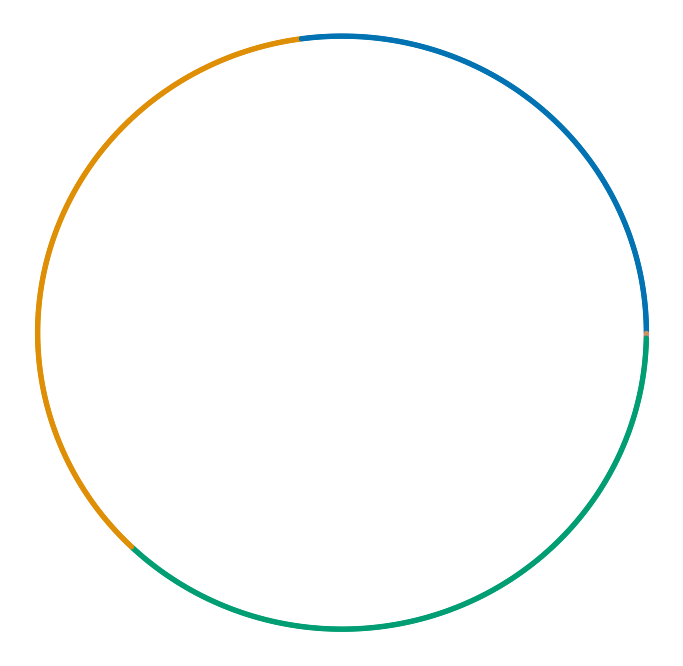

In [100]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# dibujamos los nodos en sus posiciones
nx.draw_networkx_nodes(network, ax=ax, pos=circular_positions, 
                 node_color=[node_colors[n] for n in network.nodes],
                 node_size=20,
                 with_labels=False)

# dibujamos las aristas que hemos calculado
#edge_collection = LineCollection(edge_lines, color=edge_colors, linewidth=1, linestyle='solid', alpha=0.1)
#ax.add_collection(edge_collection)

ax.set_axis_off()

In [ ]:
positions = nx.drawing.nx_pydot.graphviz_layout(network, prog='neato')
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(network, ax=ax, pos=positions)
ax.set_axis_off()

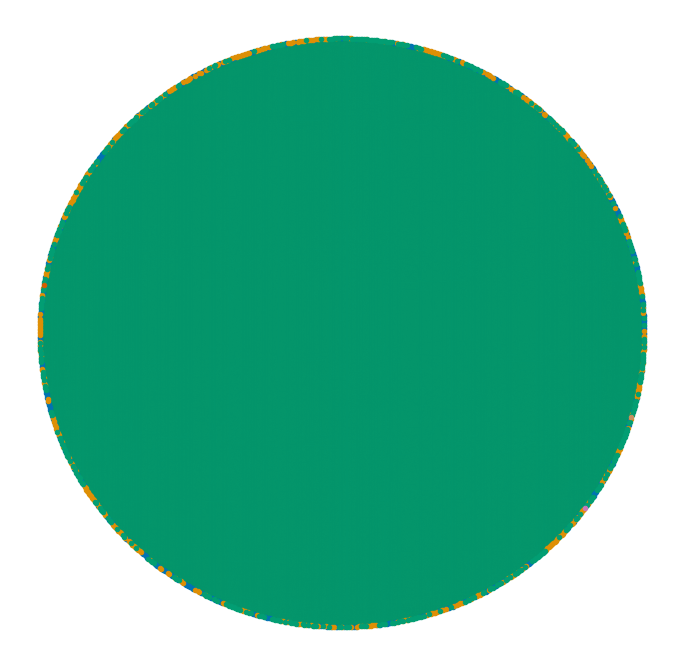

In [102]:
# nota: el código es el mismo de antes, solamente cambiamos la posición de los nodos
pos = nx.layout.circular_layout(network)

fig, ax = plt.subplots(1, 1, figsize=(12,12))

nx.draw_networkx_edges(network, pos=pos, edge_color='#abacab', node_size=0, alpha=0.25)

for community_id, color in enumerate(palette, start=0):
    community_nodes = valfilter(lambda x: x == community_id, communities).keys()
    community_graph = nx.subgraph(network, community_nodes)

    nx.draw_networkx_edges(community_graph, pos=pos, edge_color=color, node_size=0, alpha=0.1)
    nx.draw_networkx_nodes(community_graph, pos=pos, node_color=color, node_size=20, with_labels=False)

plt.axis('off');